## **Import Library**

In [ ]:
import numpy as np
import pandas as pd
import cv2
import keras
from numpy import random
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D
from keras.layers import MaxPooling2D, BatchNormalization
from keras.optimizers import SGD
from keras.applications import MobileNet, VGG16, ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report ,confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import os

## **Load Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Dataset/datafixbanget.zip"

Archive:  /content/drive/MyDrive/Dataset/datafixbanget.zip
   creating: data ml/
   creating: data ml/test/
   creating: data ml/test/r01/
  inflating: data ml/test/r01/S091R01_channel_0.png  
  inflating: data ml/test/r01/S091R01_channel_1.png  
  inflating: data ml/test/r01/S091R01_channel_2.png  
  inflating: data ml/test/r01/S092R01_channel_0.png  
  inflating: data ml/test/r01/S092R01_channel_1.png  
  inflating: data ml/test/r01/S092R01_channel_2.png  
  inflating: data ml/test/r01/S093R01_channel_0.png  
  inflating: data ml/test/r01/S093R01_channel_1.png  
  inflating: data ml/test/r01/S093R01_channel_2.png  
  inflating: data ml/test/r01/S094R01_channel_0.png  
  inflating: data ml/test/r01/S094R01_channel_1.png  
  inflating: data ml/test/r01/S094R01_channel_2.png  
  inflating: data ml/test/r01/S095R01_channel_0.png  
  inflating: data ml/test/r01/S095R01_channel_1.png  
  inflating: data ml/test/r01/S095R01_channel_2.png  
  inflating: data ml/test/r01/S096R01_channel_0.png

## **Set Folder Dataset**

In [ ]:
train_folder = "/content/data ml/train"
valid_folder = "/content/data ml/validation"
test_folder = "/content/data ml/test"

## **Show Dataset Number Each Folder**

In [ ]:
print("\n\n\t\tTraining Set")
print("\t  ========================\n")
train_c = []
for folder in os.listdir(train_folder):
    train_c.append(folder)
    print("\nTrain "+ folder + " Class: ", len(os.listdir(train_folder + '/' + folder)))

print("\n\n", train_c)

print("\n\n\t\tTesting Set")
print("\t  ========================\n")
test_c = []
for folder in os.listdir(test_folder):
    test_c.append(folder)
    print("\nTest "+ folder + " Class: ", len(os.listdir(test_folder + '/' + folder)))

print("\n\n", test_c)

print("\n\n\t\tValidation Set")
print("\t  ========================\n")
val_c = []
for folder in os.listdir(valid_folder):
    val_c.append(folder)
    print("\nValidation "+ folder + " Class: ", len(os.listdir(valid_folder + '/' + folder)))

print("\n\n", val_c, "\n")



		Training Set


Train r01 Class:  219

Train r02 Class:  219

Train r03 Class:  219


 ['r01', 'r02', 'r03']


		Testing Set


Test r01 Class:  57

Test r02 Class:  57

Test r03 Class:  57


 ['r01', 'r02', 'r03']


		Validation Set


Validation r01 Class:  51

Validation r02 Class:  51

Validation r03 Class:  51


 ['r01', 'r02', 'r03'] 



## **Data Preprocessing (Augmentation and Normalization)**

In [ ]:
input_shape = (224,224,3)
num_class = 3

train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

val_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,
)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
)


test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle = False,
)

validation_generator = val_datagen.flow_from_directory(
    valid_folder,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
)

Found 657 images belonging to 3 classes.
Found 171 images belonging to 3 classes.
Found 153 images belonging to 3 classes.


## **Load VGG16 Model as Transfer Learning**

In [ ]:
modelVGG16 = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = input_shape)

for layer in modelVGG16.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 2s 0us/step


## **Set Model Architecture**

In [ ]:
model = Sequential([
    modelVGG16,
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(.3),
    Flatten(),
    Dense(1024, activation = 'relu'),
    Dropout(.3),
    Dense(512, activation = 'relu'),
    Dropout(.3),
    Dense(256, activation = 'relu'),
    Dropout(.3),
    Dense(num_class, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization (Batch  (None, 7, 7, 512)         2048      
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 512)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 3, 3, 512)         0         
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 1024)              4

## **Optimizer Configuration**

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
opt2 = tf.keras.optimizers.RMSprop(learning_rate = 0.001)

model.compile(loss = 'categorical_crossentropy',
             optimizer = opt,
             metrics = ['accuracy'])

## **Training Model**

In [ ]:
epochs = 50

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    verbose=1
)
test = test_generator
score = model.evaluate(test, verbose = 1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epoch 1/50
21/21 [==============================] - 39s 1s/step - loss: 1.3856 - accuracy: 0.6088 - val_loss: 1.3805 - val_accuracy: 0.7190
Epoch 2/50
21/21 [==============================] - 17s 823ms/step - loss: 0.8723 - accuracy: 0.7062 - val_loss: 0.6652 - val_accuracy: 0.6405
Epoch 3/50
21/21 [==============================] - 17s 815ms/step - loss: 0.6470 - accuracy: 0.7336 - val_loss: 0.3869 - val_accuracy: 0.7843
Epoch 4/50
21/21 [==============================] - 18s 817ms/step - loss: 0.5302 - accuracy: 0.7443 - val_loss: 0.3589 - val_accuracy: 0.8105
Epoch 5/50
21/21 [==============================] - 18s 860ms/step - loss: 0.4783 - accuracy: 0.7671 - val_loss: 0.3609 - val_accuracy: 0.8301
Epoch 6/50
21/21 [==============================] - 17s 814ms/step - loss: 0.4249 - accuracy: 0.7945 - val_loss: 0.3743 - val_accuracy: 0.7974
Epoch 7/50
21/21 [==============================] - 18s 880ms/step - loss: 0.3767 - accuracy: 0.8280 - val_loss: 0.3502 - val_accuracy: 0.8301
Ep

## **Evaluate Model on Test Data**

In [ ]:
num_test_samples = len(test_generator)
num_classes = len(test_generator.class_indices)

predicted_probabilities = model.predict(test_generator, steps=num_test_samples)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

true_labels = test_generator.classes

report = classification_report(true_labels, predicted_labels)

print(report)

6/6 [==============================] - 2s 315ms/step
              precision    recall  f1-score   support

           0       0.75      0.77      0.76        57
           1       0.76      0.72      0.74        57
           2       0.98      1.00      0.99        57

    accuracy                           0.83       171
   macro avg       0.83      0.83      0.83       171
weighted avg       0.83      0.83      0.83       171



## **Show Confusion Matrix**



Confusion Matrix:
 [[44 13  0]
 [15 41  1]
 [ 0  0 57]]


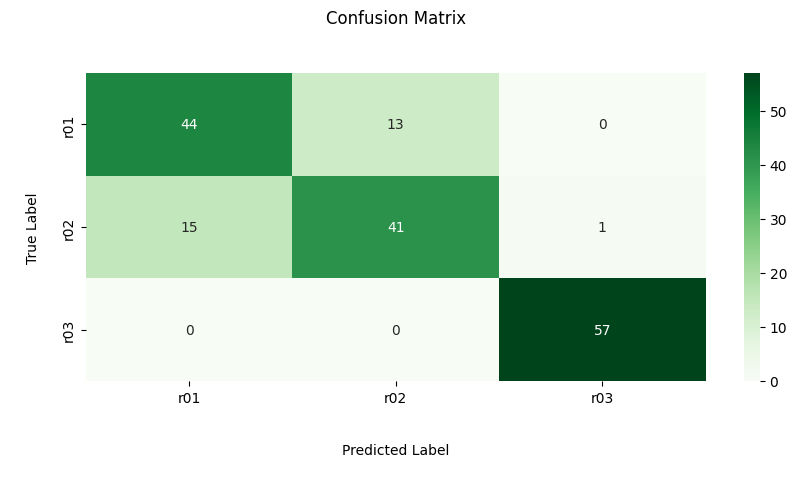

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)
print("\n\nConfusion Matrix:\n", cm)

plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', xticklabels = test_c, yticklabels = test_c)
plt.xlabel('\n\nPredicted Label\n')
plt.ylabel('\nTrue Label\n')
plt.title('Confusion Matrix\n\n')
plt.show()

## **Loss and Accuracy Visuzalization**

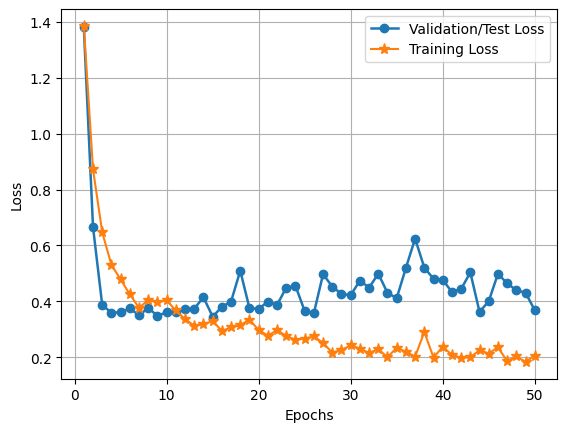

In [ ]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.0)
plt.setp(line2, linewidth = 1.5, marker = '*', markersize = 8.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

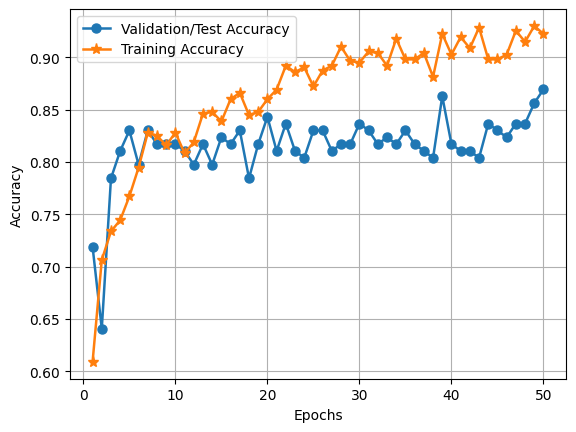

In [ ]:
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.5)
plt.setp(line2, linewidth = 1.8, marker = '*', markersize = 8.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

## **Export Model**

In [ ]:
model.save('finalModel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
